In [ ]:
#import packages
import numpy as np
import networkx as nx
from random import choice
import matplotlib.pyplot as plt

In [ ]:
#performance metrics

def compute_efficiency(G):
  '''This function takes a networkx graph and computes its efficiency.'''
  #print(apsp)
  n = G.number_of_nodes()
  if n<2:
    return 0 #networks with 1 or 0 nodes can easily reach "all" their neighbors
  apsp = list(nx.all_pairs_shortest_path(G))
  pairwise_efficiencies = np.zeros((n,n))
  for i_index, i in enumerate(G.nodes()):
    #print('i', i)
    for tup in apsp:
      if tup[0]==i:
        path_dict = tup[1]
    #path_dict = apsp[i_index][1]
    for j_index, j in enumerate(G.nodes()):
      #print('j',j)
      if i!=j:
        if j in path_dict.keys():
          p = path_dict[j]
          if len(p) > 1:
            pairwise_efficiencies[i_index,j_index] = 1/(len(p)-1)
  efficiency = np.sum(pairwise_efficiencies)/(n*(n-1))
  return efficiency
  #taken from Jessica's notebook 4/4

def degree_distr(x, G):
  array = G.degree
  degree_count = 0
  for node in G.degree:
    if node[1] == x:
      degree_count += 1
  return degree_count / G.number_of_nodes()

def mean_shortest_path(graph):
  if nx.number_of_nodes(graph) == 0:
    return 0
  else:
    n = len(max(nx.connected_components(graph), key=len))
    if n<2:
      return np.nan
    apsp = list(nx.all_pairs_shortest_path(graph))
    shortest_distances = np.zeros((n,n))
    for i_index, i in enumerate(max(nx.connected_components(graph), key=len)):
      #print('i', i)
      for tup in apsp:
        if tup[0]==i:
          path_dict = tup[1]
      #path_dict = apsp[i_index][1]
      for j_index, j in enumerate(max(nx.connected_components(graph), key=len)):
        #print('j',j)
        if i!=j:
          if j in path_dict.keys():
            p = path_dict[j]
            if len(p) > 1:
              shortest_distances[i_index,j_index] = len(p)-1
    mean_shortest = np.sum(shortest_distances) / scipy.special.comb(n, 2)
    return mean_shortest

In [ ]:
#supported performance metrics: number_of_nodes, largest_connected_component, 
#efficiency, entropy, mean shortest path, average cluster size, relative LCC,
#reachability, transitivity, resistance distance, natural connectivity

def computeRobustnessCurve(g, remove_nodes='random', performance='largest_connected_component'):
  #takes in a graph, removal strategy, and performance metric to measure robustness over one trial
  #helper function for computeRobustnessCurves

  # compute the maximum number of nodes to be removed
  n = g.number_of_nodes()

  data_array = np.zeros((2,n), dtype=float) 
  #2 rows of n columns each: top row is number of nodes removed, bottom row is performance measurement
  data_array[0] = np.arange(n)

  if performance=='number_of_nodes':

    def computePerformance(graph):
      output = graph.number_of_nodes()
      return output

  elif performance=='largest_connected_component':

    def computePerformance(graph):
      if(graph.number_of_nodes() == 0):
        return 0
      else:
        nodes_in_cluster = len(max(nx.connected_components(graph), key=len))
        return nodes_in_cluster

  elif performance=='efficiency':

    def computePerformance(graph):
      return compute_efficiency(graph)

  elif performance == "entropy":

    def computePerformance(graph):
      if nx.number_of_nodes(graph) == 0:
        return 0
      else:
        max_degree = sorted(graph.degree, key=lambda x: x[1], reverse=True)[0][1]
        H = 0
        for i in range(max_degree):
          p_k = degree_distr(i, graph)
          H += p_k * np.log(p_k)
        return -H

  elif performance == "mean shortest path":
    def computePerformance(graph):
      return mean_shortest_path(graph)

  elif performance == "average cluster size":
    def computePerformance(graph):
      n = nx.number_of_nodes(graph)
      n_c = nx.connected_components(graph)
      return n/n_c

  elif performance == "relative LCC":

    def computePerformance(graph):
      if(graph.number_of_nodes() == 0):
          return 0
      else:
        nodes_in_cluster = len(max(nx.connected_components(graph), key=len))
        return nodes_in_cluster / graph.number_of_nodes()

  elif performance == "reachability":

    def computePerformance(graph):
      N = graph.number_of_nodes()
      if N==0:
        return 0
      else:
        reach = 0
        # replace
        for i_index, i in enumerate(N, key=len):
          for j_index, j in enumerate(N, key=len):
            if i!=j:
              if nx.has_path(i, j) == True:
                reach += 1

      return .5 * 1/(np.comb(N, 2)) * reach

  elif performance == "transitivity":

    def computePerformance(graph):
      return nx.transitivity(graph)

  elif performance == "resistance distance":
    def computePerformance(graph):
      N = graph.number_of_nodes()
      L = nx.laplacian_matrix(graph)
      L_plus = np.linalg.pinv(L)

      return N * np.trace(L_plus)

  # elif performance == "resistance distance":
  # def computePerformance(graph):
  #   N = graph.number_of_nodes()
  #   L = nx.laplacian_matrix(graph)
  #   L_plus = np.linalg.pinv(L)

  #   return N * np.(L_plus) is it np. or np.trace?
  
  elif performance == "natural connectivity":
    def computePerformance(graph):
      N = graph.number_of_nodes()
      return np.log(np.trace(nx.communicability_matrix(graph))) - np.log(N)
      
  else:
    print('Error: I dont know that performance value')
    return 0


  for i in range(n):
    #find a node to remove
    if remove_nodes == 'random':
      v = choice(list(g.nodes()))
    elif remove_nodes == 'attack':
      v = sorted(g.degree, key=lambda x: x[1], reverse=True)[0][0] 
    else:
      print('Error: I dont know that mode of removing nodes')
      v = None #will this error?

    g.remove_node(v)
   
    data_array[1,i] = computePerformance(g)

  return data_array


In [ ]:
# constructs an ER(random) or SF (exponential) network–helper function for computeRobustnessCurves and computeRobustnessData

def construct_a_network(number_of_nodes, number_of_edges, graph_type): #n = #nodes, m = #edges
  if graph_type == 'ER':
    p = 2*number_of_edges*(number_of_nodes-number_of_edges)/(number_of_nodes*(number_of_nodes-1))
    g = nx.erdos_renyi_graph(number_of_nodes, p, seed=None, directed=False)
    return g
  elif graph_type == 'SF':
    g2 = nx.barabasi_albert_graph(number_of_nodes, number_of_edges)
    return g2
  else:
    print("Error: invalid graph_type")

In [ ]:
def computeRobustnessCurves(number_of_nodes=100, number_of_edges=20, graph_type='ER', remove_nodes='random', performance='largest_connected_component', num_trials=10):
  #constructs a network and runs computeRobustnessCurves over given amount of trials; helper for completeRobustnessData

  data_array = np.zeros((num_trials+1,number_of_nodes), dtype=float)
  data_array[0] = np.arange(number_of_nodes)

  for i in range(num_trials):
    g = construct_a_network(number_of_nodes=number_of_nodes, number_of_edges=number_of_edges, graph_type=graph_type)
    # print(g)
    # print(graph_type)
    # print(g.nodes)
    data = computeRobustnessCurve(g, remove_nodes=remove_nodes, performance=performance)
    data_array[i+1] = data[1]

  return data_array #2d array for performance over removing n nodes, num_trials trials


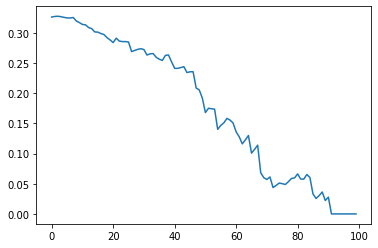

In [ ]:
data = computeRobustnessCurves(number_of_nodes=100, number_of_edges=2, graph_type='ER', # parameters for graph construction
                        remove_nodes='random', performance='efficiency' #parameter for robustness computation
                        )

# plot data
plt.plot(data[0], data[1]) 
#plot represents efficiency of a random network with 100 nodes, 2 edges per node, as nodes are randomly removed
#data[0] represents nodes removed
#data[1] represents efficiency after removing each node over one trial

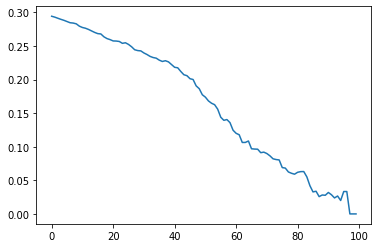

In [ ]:
mean_performance = data[1]
for trial in data[2:10]:
  mean_performance += np.array(trial)
  # print(trial)

mean_performance /= 10

plt.plot(data[0], mean_performance)
plt.show()

#plotted same efficiency data from above cell, averaging efficiency over all 10 trials

In [ ]:
#takes in parameters for graph type, number of nodes, number of edges per node, 
# remove strategies, and performance metrics
#helper function for plot_graphs

def completeRobustnessData(graph_types=['ER', 'SF'], 
                           numbers_of_nodes=np.arange(20, 101, 20), 
                           #20,101,20: i.e., 20, 40 ,60, 80, 100 nodes 
                           numbers_of_edges=[1,2,3], 
                           remove_strategies = ['random', 'attack'], 
                           performance='efficiency'):
  # initialize some big list
  LIST = [[[[0 for i in range(len(remove_strategies))] 
            for j in range(len(numbers_of_edges))] 
           for k in range(len(numbers_of_nodes))] 
          for l in range(len(graph_types))]

  #LIST = []
  #for l in range(len(graph_types)):
  #  LIST.append([])
  #  for k in range(len(numbers_of_nodes)):
  #    LIST[-1].append([])

  for i_gt, graph_type in enumerate(graph_types): 
    #enumerate() indexes each graph_type in graph_types
    for i_nn, number_of_nodes in enumerate(numbers_of_nodes):
      for i_ne, number_of_edges in enumerate(numbers_of_edges):
        for i_rs, remove_strategy in enumerate(remove_strategies):

          data = computeRobustnessCurves(graph_type=graph_type, 
                                         number_of_nodes=number_of_nodes, 
                                         number_of_edges = number_of_edges, 
                                         performance=performance)
          LIST[i_gt][i_nn][i_ne][i_rs] = data
  return LIST

  #returns 6-dimensional array indicating performance over removing 
  #n nodes, num_trials times, 

In [ ]:
def plotLineGraphs(data_array, graph_types=['ER', 'SF'], 
                           numbers_of_nodes=np.arange(20,101,20), 
                           numbers_of_edges=[1,2,3], 
                           remove_strategies = ['random', 'attack'], 
                           performance='efficiency'): 
                           #plots line graphs from data generated from 
                           #computeRobustnessCurves
                           #one line graph per trial
  plt.figure()

  k = 0

  for i_gt, graph_type in enumerate(graph_types):
    for i_rs, remove_strategy in enumerate(remove_strategies):
      plt.subplot(4,2,1+k) #error here: ask for help on subplot

      for i_nn, number_of_nodes in enumerate(numbers_of_nodes):

        data_for_subplot = data_array[i_gt][i_nn][0][i_rs]

        plt.plot(data_for_subplot[0], np.mean(data_for_subplot[1:], axis=0), label='n='+str(number_of_nodes))

        k += 1
        #k increases by 1 for each new attribute being varied.

  for i_gt, graph_type in enumerate(graph_types):
    for i_rs, remove_strategy in enumerate(remove_strategies):
      plt.subplot(4,2,1+k)

      for i_ne, number_of_edges in enumerate(numbers_of_edges):

        data_for_subplot = data_array[i_gt][0][i_ne][i_rs]

        plt.plot(data_for_subplot[0], np.mean(data_for_subplot[1:], axis=0), label='m='+str(number_of_edges))

        k += 1

    

  
  #for i in range(len(data_array)-1):
  #    plt.plot(data_array[0], data_array[i+1]) #index is i+1 because first row is number of nodes removed, so you have to skip by adding one.

  ##plt.subplot(1, 2, 2)
  #for i in range(len(data_array)-1):
  #  plt.plot(data_array[i+1], data_array[0])

In [ ]:
DATA = completeRobustnessData(graph_types=['ER', 'SF'], 
                           numbers_of_nodes=np.arange(20,101,20), 
                           numbers_of_edges=[1,2,3], 
                           remove_strategies = ['random', 'attack'], 
                           performance='efficiency')

ValueError: ignored

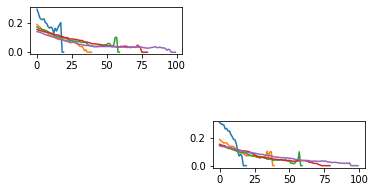

In [ ]:
plotLineGraphs(DATA, graph_types=['ER', 'SF'], 
                           numbers_of_nodes=np.arange(20,101,20), 
                           numbers_of_edges=[1,2,3], 
                           remove_strategies = ['random', 'attack'], 
                           performance='efficiency') #this one generates 10 layers

In [ ]:
def plot_graphs(graph_types=['ER', 'SF'], 
                           numbers_of_nodes=np.arange(20, 101, 20), #20,101,20: i.e., 20, 40 ,60, 80, 100 nodes 
                           numbers_of_edges=[1,2,3], 
                           remove_strategies = ['random', 'attack'], 
                           performance='efficiency', to_vary = 'nodes', vary_index = 1): #figure out what vary_index did again
  LIST = completeRobustnessData(graph_types, numbers_of_nodes, numbers_of_edges, remove_strategies, performance)

  if to_vary == 'nodes':
    # start plotting
    fig = plt.figure()

    # 1. plot performance as function of n
    x = 1
    while x < 5:
      for i_gt, graph_type in enumerate(graph_types):
        for i_rs, remove_strategy in enumerate(remove_strategies):
          ax1 = plt.subplot(2,2,x) #1 subplot for every combination of graph type/rs
          x +=1
          print(x)
          for i_nn, number_of_node in enumerate(numbers_of_nodes):
                
                #generating plot
                ax1.plot(range(numbers_of_nodes[i_nn]), 
                         np.nanmean(LIST[i_gt][i_nn][vary_index][i_rs][1:], 
                                 axis = 0), 'o-', 
                         label = "number of nodes="+str(numbers_of_nodes[i_nn]))
                
                #labeling plot
                ax1.set_title(str(performance)+ " of " + str(graph_type)+
                              " graph, "+str(remove_strategy)+" removal: over "
                              + to_vary)
                ax1.legend()
                ax1.set_xlabel('n (number nodes removed)')
                ax1.set_ylabel(performance)
                
          # fig.tight_layout()
      plt.subplots_adjust(left=None, bottom=None, right=2, top=2, wspace=None, hspace=None)
      plt.show()

  elif to_vary == 'edges':
    # start plotting
    fig = plt.figure()

    # 1. plot performance as function of n, 2 * 2 * 5 figures
    x = 1
    while x < 5:
      for i_gt, graph_type in enumerate(graph_types):
        for i_rs, remove_strategy in enumerate(remove_strategies):
          ax1 = plt.subplot(2,2,x) #1 subplot for every combination of graph type/rs
          x +=1
          print(x)
          for i_ne, number_of_edge in enumerate(numbers_of_edges):
                
                #generating plot
                ax1.plot(range(numbers_of_nodes[1]), 
                         np.mean(LIST[i_gt][vary_index][i_ne][i_rs][1:], 
                            axis = 0), 'o-', 
                         label = "number of edges="+str(numbers_of_edges[i_ne]))
                
                #labeling plot
                ax1.set_title(str(performance)+ " of " + str(graph_type)+
                              " graph, "+str(remove_strategy)+" removal: over "
                              + to_vary)
                ax1.legend()
                ax1.set_xlabel('n (number nodes removed)')
                ax1.set_ylabel(performance)
                #plt.show
          # fig.tight_layout()
      plt.subplots_adjust(left=None, bottom=None, right=2, top=2, wspace=None, hspace=None)
      plt.show()

    else:
      print("Please vary either nodes or edges.")
      #safety check if user made a mistake with to_vary

In [ ]:
plot_graphs(['ER', 'SF'], np.arange(20, 101, 20), [1,2,3], ['random', 'attack'], 'efficiency')

KeyboardInterrupt: ignored

In [ ]:
plot_graphs(['ER', 'SF'], np.arange(20, 101, 20), [1,2,3], ['random', 'attack'], 'efficiency', to_vary = 'edges', vary_index = 1)

In [ ]:
#variety of plot_graphs: plots graphs given pre-generated data from completeRobustnessData
#generating completeRobustnessData is the slowest part of plot_graphs, so plot_given_data saves a lot of time

def plot_given_data(LIST, graph_types=['ER', 'SF'], 
                           numbers_of_nodes=np.arange(20, 101, 20), #20,101,20: i.e., 20, 40 ,60, 80, 100 nodes 
                           numbers_of_edges=[1,2,3], 
                           remove_strategies = ['random', 'attack'], 
                           performance='efficiency', to_vary = 'nodes', vary_index = 1):
  
  # if LIST == None:
  #   LIST = completeRobustnessData(graph_types, numbers_of_nodes, numbers_of_edges, remove_strategies, performance)
    #generate big list for completeRobustnessData if function not already passed one

  if to_vary == 'nodes':
    # start plotting
    fig = plt.figure()

    # 1. plot performance as function of n
    x = 1
    while x < 5:
      for i_gt, graph_type in enumerate(graph_types):
        for i_rs, remove_strategy in enumerate(remove_strategies):
          ax1 = plt.subplot(2,2,x) #1 subplot for every combination of graph type/rs
          x +=1
          print(x)
          for i_nn, number_of_node in enumerate(numbers_of_nodes):
                
                #generating plot
                ax1.plot(range(numbers_of_nodes[i_nn]), 
                         np.mean(LIST[i_gt][i_nn][vary_index][i_rs][1:], 
                                 axis = 0), 'o-', 
                         label = "number of nodes="+str(numbers_of_nodes[i_nn]))
                
                #labeling plot
                ax1.set_title(str(performance)+ " of " + str(graph_type)+
                              " graph, "+str(remove_strategy)+" removal: over "
                              + to_vary)
                ax1.legend()
                ax1.set_xlabel('n (number nodes removed)')
                ax1.set_ylabel(performance)
                
          # fig.tight_layout()
      plt.subplots_adjust(left=None, bottom=None, right=2, top=2, wspace=None, hspace=None)
      plt.show()

  elif to_vary == 'edges':
    # start plotting
    fig = plt.figure()

    # 1. plot performance as function of n, 2 * 2 * 5 figures
    x = 1
    while x < 5:
      for i_gt, graph_type in enumerate(graph_types):
        for i_rs, remove_strategy in enumerate(remove_strategies):
          ax1 = plt.subplot(2,2,x) #1 subplot for every combination of graph type/rs
          x +=1
          print(x)
          for i_ne, number_of_edge in enumerate(numbers_of_edges):
                
                #generating plot
                ax1.plot(range(numbers_of_nodes[1]), 
                         np.mean(LIST[i_gt][vary_index][i_ne][i_rs][1:], 
                            axis = 0), 'o-', 
                         label = "number of edges="+str(numbers_of_edges[i_ne]))
                
                #labeling plot
                ax1.set_title(str(performance)+ " of " + str(graph_type)+
                              " graph, "+str(remove_strategy)+" removal: over "
                              + to_vary)
                ax1.legend()
                ax1.set_xlabel('n (number nodes removed)')
                ax1.set_ylabel(performance)
                #plt.show
          # fig.tight_layout()
      plt.subplots_adjust(left=None, bottom=None, right=2, top=2, wspace=None, hspace=None)
      plt.show()

    else:
      print("Please vary either nodes or edges.")
      #safety check if user made a mistake with to_vary

2
3
4
5


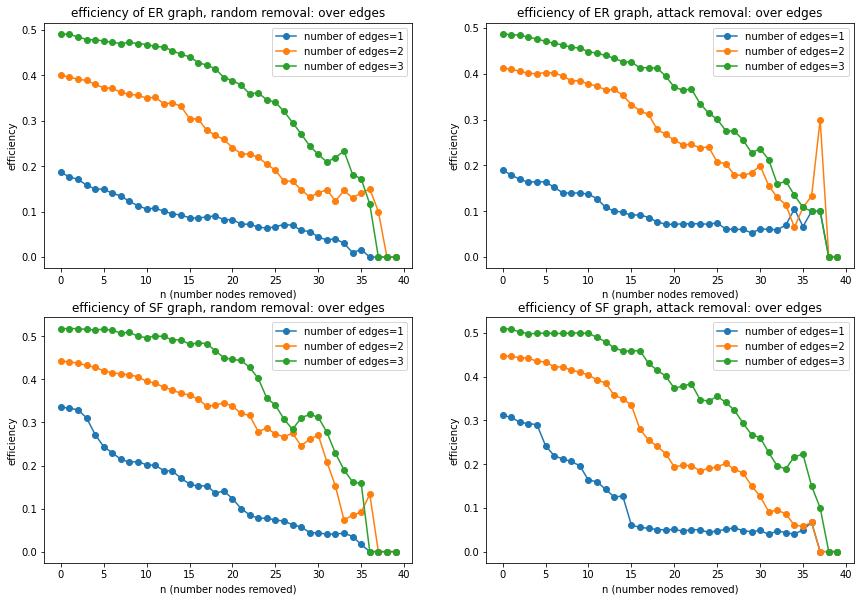

Please vary either nodes or edges.


In [ ]:
plot_given_data(DATA, to_vary = 'edges')
#testing plot_given_data

In [ ]:
def riemann_percent(array):
  biggest = array[0]
  return np.sum(array) * (1 / array.size) / biggest

  #takes riemann sum over entire performance over nodes removed curve for one array

In [ ]:
DATA
#4 layers, then array[[]], array[[]]... array[i[0]] is always nodes removed, ignore
#riemann over array[i[1:]] for all arrays inside

In [ ]:
#how to loop through data s.t. we take the riemann sum of every trial?
#below cells are *rough*

In [ ]:
def plot_riemann_data(LIST, graph_types=['ER', 'SF'], 
                           numbers_of_nodes=np.arange(20, 101, 20), #20,101,20: i.e., 20, 40 ,60, 80, 100 nodes 
                           numbers_of_edges=[1,2,3], 
                           remove_strategies = ['random', 'attack'], 
                           performance='efficiency', to_vary = 'nodes', vary_index = 1):

  
  num_trials = len(LIST[0][0][0][0][1:])

  if to_vary == 'nodes':
    # start plotting
    fig = plt.figure()

    # 1. plot robustness over multiple network sizes
    x = 1
    while x < 5:
      for i_gt, graph_type in enumerate(graph_types):
        for i_rs, remove_strategy in enumerate(remove_strategies):
          ax1 = plt.subplot(2,2,x) #1 subplot for every combination of graph type/rs
          x +=1
          # print(x)
          riemann_data = []
          for i_nn, number_of_node in enumerate(numbers_of_nodes):
                res = [riemann_percent(LIST[i_gt][i_nn][vary_index][i_rs][1:][i]) for i in range(num_trials)]
                riemann_data.append(np.mean(res))
                # print(i_nn, riemann_data)
          plt.plot(numbers_of_nodes, riemann_data)

                #labeling plot
          ax1.set_title("robustness by " + str(performance)+ " of " + str(graph_type)+
                 " graph, "+str(remove_strategy)+" removal: over "
                + to_vary)
          # ax1.legend() #legend shows blank white box
          ax1.set_xlabel('initial network size')
          ax1.set_ylabel("mean riemann percent of " + performance)
                
          fig.tight_layout()
      plt.subplots_adjust(left=None, bottom=None, right=2, top=2, wspace=None, hspace=None)
      plt.show()

  elif to_vary == 'edges':
    # start plotting
    fig = plt.figure()

    # 1. plot performance as function of n, 2 * 2 * 5 figures
    x = 1
    while x < 5:
      for i_gt, graph_type in enumerate(graph_types):
        for i_rs, remove_strategy in enumerate(remove_strategies):
          ax1 = plt.subplot(2,2,x) #1 subplot for every combination of graph type/rs
          x +=1
          # print(x)
          riemann_data = []
          for i_ne, number_of_edge in enumerate(numbers_of_edges):
                res = [riemann_percent(LIST[i_gt][vary_index][i_ne][i_rs][1:][i]) for i in range(num_trials)]
                riemann_data.append(np.mean(res))
                # print(i_nn, riemann_data)
          plt.plot(numbers_of_edges, riemann_data)

                #labeling plot
          ax1.set_title("robustness by " + str(performance)+ " of " + str(graph_type)+
                 " graph, "+str(remove_strategy)+" removal: over "
                + to_vary)
          # ax1.legend() #legend shows blank white box
          ax1.set_xlabel('edges per node')
          ax1.set_ylabel("mean riemann percent of " + performance)
                
          fig.tight_layout()
      plt.subplots_adjust(left=None, bottom=None, right=2, top=2, wspace=None, hspace=None)
      plt.show()

    else:
      print("Please vary either nodes or edges.")
      #safety check if user made a mistake with to_vary

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


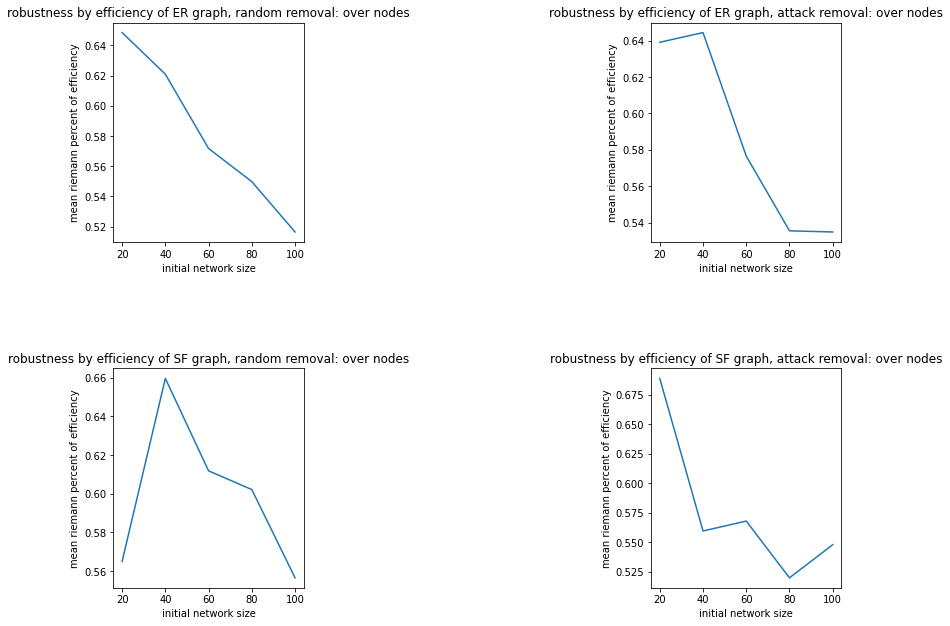

In [ ]:
plot_riemann_data(DATA)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


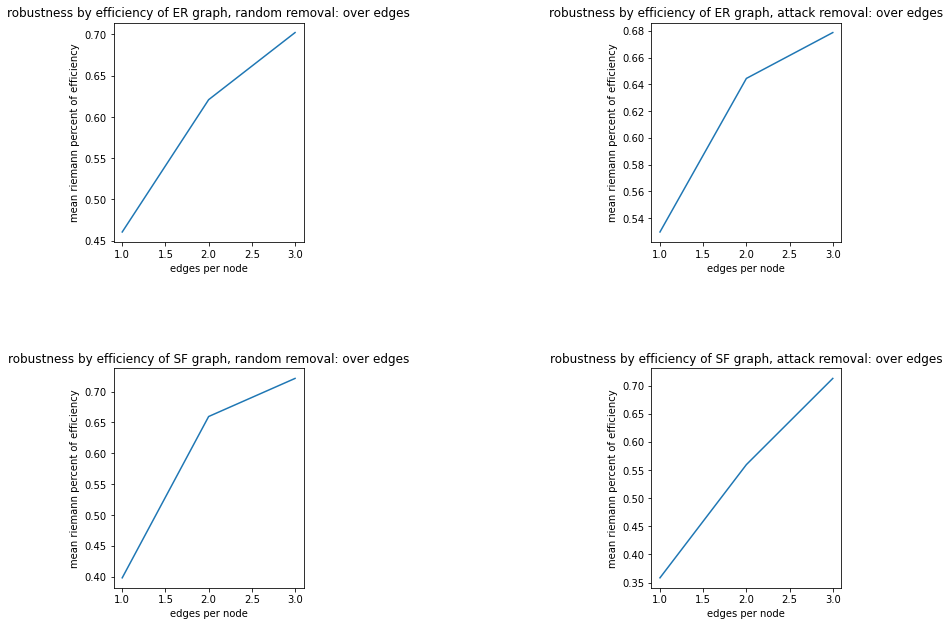

Please vary either nodes or edges.


In [ ]:
plot_riemann_data(DATA, to_vary = 'edges')

In [ ]:
DATA[0][0][1][0][1:][0]
#have to go through this many layers before taking riemann_percent()

In [ ]:
riemann_percent(DATA[0][0][1][0][1:][0])

2
3
4
5


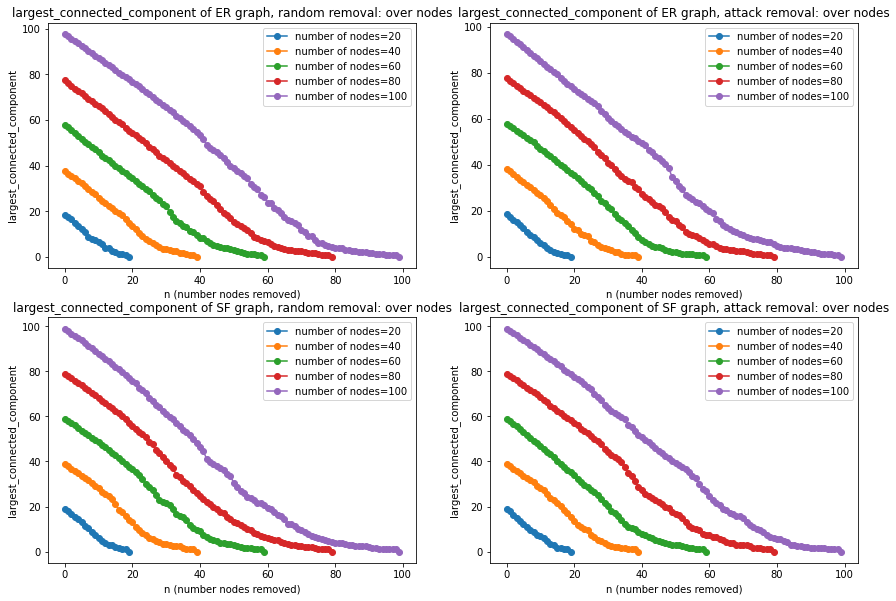

In [ ]:
LCC_LIST = plot_graphs(graph_types=['ER', 'SF'], 
                           numbers_of_nodes=np.arange(20, 101, 20), #20,101,20: i.e., 20, 40 ,60, 80, 100 nodes 
                           numbers_of_edges=[1,2,3], 
                           remove_strategies = ['random', 'attack'], 
                           performance='largest_connected_component', to_vary = 'nodes', vary_index = 1)

#supported performance metrics: number_of_nodes, largest_connected_component, 
#efficiency, entropy, mean shortest path, average cluster size, relative LCC,
#reachability, transitivity, resistance distance, natural connectivity

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in double_scalars


2
3
4
5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of em

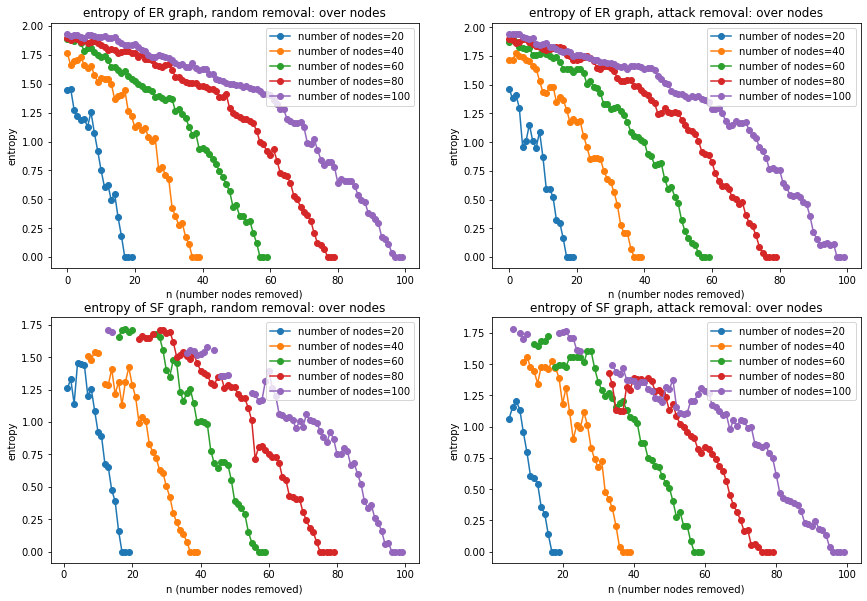

In [ ]:
plot_graphs(graph_types=['ER', 'SF'], 
                           numbers_of_nodes=np.arange(20, 101, 20), #20,101,20: i.e., 20, 40 ,60, 80, 100 nodes 
                           numbers_of_edges=[1,2,3], 
                           remove_strategies = ['random', 'attack'], 
                           performance='entropy', to_vary = 'nodes', vary_index = 1)

In [ ]:
plot_graphs(performance='mean shortest path') #ask jessica

In [ ]:
pip install scipy

In [ ]:
plot_graphs(performance='reachability')

In [ ]:
plot_graphs(performance='natural connectivity')

In [ ]:
#jessica's code from 5/9
from random import choice
import scipy.special
import matplotlib.pyplot as plt

def angle_simulate(graph): # create a graph and set x values in it? or we could set a parameter for every node, which would be a lot
  n = nx.number_of_nodes(graph)
  all_angle_arrays = np.zeros(n)
  cycle_array = np.zeros(n)
  n_cycles = range(0, n+1)

  # while or some loop that goes until all the new_x_i's are equal? (basically keep cycles of calculating x for all nodes going until they are the same)
  cycle = 1
  for i in enumerate(n_cycles):
    angle_array = np.zeros(n) # get n axes? or make as many arrays as necessary until all the angles are equal
    new_x_i = scipy.pi
    for j_index, j in enumerate(max(nx.connected_components(graph), key=len)):
        if i!=j:
          new_x_i += nx.adjacency_matrix(graph) * scipy.sin(x_j - x_i) # somehow ned to be able to define x_i for each node i in the graph
          angle_array += new_x_i
    all_angle_arrays += angle_array
    cycle_array += cycle
    cycle += 1

# graphing data
  plt.figure()
  plt.subplot(121)
  for i in range(n):
    data_array = np.zeros(n)
    for angle_array in all_angle_arrays:
      data_array += angle_array[i]
      plt.plot(cycle_array, data_array,'o-', label = "node" + str(i))
  plt.legend()
  plt.set_xlabel('cycles')
  plt.set_ylabel("angular velocity")
  fig = plt.figure()


In [ ]:
import scipy

In [ ]:
#for next time: transfer riemann to varying number of edges
#program legends/axis labels into riemann (done)
#function: input graph, plot performance over nodes removed for network put in
#compare to random graph with same number of nodes/edges

#real world graph: adjacency matrix (assume undirected); cnovert to nx graph, run in-built functions for nodes/edges

In [ ]:
def process_matrix(am):
  #am is the adjacency matrix for the graph
  
# def compare_to_real_graph(adjacency):